# IEEE-CIS Fraud Detection(거래 사기 탐지) EDA_KJG

- [IEEE-CIS Fraud Detection(거래 사기 탐지)](https://www.kaggle.com/c/ieee-fraud-detection)
- IEEE-CIS?
    - IEEE Computational Intelligence Society

---

## Data Description

- In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target `isFraud`

- The data is broken into two files `identity` and `transaction`, which are joined by `TransactionID`.  
    - Not all transactions have corresponding identity information.

---

- **Transaction Table**

|Data|Description|
|:----:|:---------:|
| TransactionDT | timedelta from a given reference datetime (not an actual timestamp) |
| TransactionAMT | transaction payment amount in USD |
| ProductCD | product code, the product for each transaction |
| addr | address |
| dist | distance |
| P_ and (R__) emaildomain | purchaser and recipient email domain |
| C1-C14 | counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. |
| D1-D15 | timedelta, such as days between previous transaction, etc. |
| M1-M9 | match, such as names on card and address, etc. |
| Vxxx | Vesta engineered rich features, including ranking, counting, and other entity relations. |

---

- **Identity Table**
|Data|Description|
|:-------:|:--------:|
| DeviceType | 기기 타입 |
| DeviceInfo | [기기 정보](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#583227) |

  
  
- **기기정보**
```
"id01부터 id11은 Vesta와 보안 파트너들이 기기 등급, ip_domain 등급, 프록시 등급 등과 같이 수집한 ID에 대한 수치 기능입니다.
또한 계정 로그인 시간/로그인 실패 시간, 계정이 페이지에 남아 있는 시간 등 행동 지문을 기록했습니다.
이 모든 것은 보안 파트너인 T&C 때문에 자세히 설명할 수 없습니다. 
이러한 기능의 기본적인 의미를 파악하여 수치/범주로 언급함으로써 부적절하게 처리하지 않기를 바랍니다."
```

---

## data 보고 직관적으로 생각해보기

### Transaction Table

- TransactionDT
    - 주어진 reference datetime 으로부터의 timedelta(ms) 값
    - 거래 사기가 많은 시간대가 있는지 확인.
    
- TransactionAMT
    - 거래 금액
    - 거래 금액의 규모에 따라 거래 사기가 많은 거래 금액 규모 확인.
    
- ProductCD **(범주형)**
    - 제품코드
    - 어떤 품목일지 확인해서 거래 사기가 많은 품목 체크 -> 가능🤔?
    
- addr **(범주형)**
    - 주소 
    - 상관 있을까?
    
- dist **(범주형)**
    - 거리
    - 상관 있을까?
    
- P_ and (R__) emaildomain **(범주형)**
    - 구매자와 판매자의 이메일 도메인
    - 거래 사기가 많은 도메인 확인

- C1-C14
    - 개인 정보라서 실제 의미는 알 수 없음.

- D1-D15 
    - timedelta 값 (ex. 이전 거래한 날짜와의 시간 차이)

- M1-M9	**(범주형)**
    - 개인 정보의 일치 정보

- Vxxx
    - Vesta사에서 고객군 관리를 위해 만들어낸 변수
    - 랭킹, 카운팅, 관계, ect

### Identity Table

- 거래와 관련된 식별정보 **(범주형)**
    - 네트워크 연결정보
    - 디지털 서명 정보

- DeviceType
- DeviceInfo
- id12 ~ id38

---

In [7]:
# 필요한 라이브러리 Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# raw data path 지정
data_path = "../../data/raw/"

In [16]:
# data 불러오기

## Transaction data loading
### index 통합
train_trans = pd.read_csv( data_path + "train_transaction.csv", index_col='TransactionID')
test_trans = pd.read_csv ( data_path + "test_transaction.csv", index_col='TransactionID')

## Identity data loading
### index 통합
train_id = pd.read_csv( data_path + "train_identity.csv", index_col='TransactionID')
test_id = pd.read_csv( data_path + "test_identity.csv", index_col='TransactionID')

In [21]:
train_trans.head(3)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
train_id.head(3)

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


## 데이터 전처리

In [17]:
# data check function

def data_check(df):
    print("rows:", df.shape[0], 'columns:', df.shape[1])
    
data_check(train_trans)
data_check(test_trans)
data_check(train_id)
data_check(test_id)

In [22]:
# data merging

## train = train_trans + train_id
train = train_trans.merge(train_id, how='left', left_index=True, right_index=True)

## test = test_trans + test_id
test = test_trans.merge(test_id, how='left', left_index=True, right_index=True)

In [23]:
# merging data check
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.9+ GB


- train의 data는 총 3가지
    
|종류|변수 타입|
|:-:|:-----:|
|float64|연속형 - 실수|
|int64|연속형 - 정수|
|object|범주형|

In [59]:
# 결측치 check

null_df = train.isnull().sum().reset_index()
null_df.columns = ['column_name', 'null_count']
null_df

,column_name,null_count
0,isFraud,0
1,TransactionDT,0
2,TransactionAmt,0
3,ProductCD,0
4,card1,0
...,...,...
428,id_36,449555
429,id_37,449555
430,id_38,449555
431,DeviceType,449730


In [62]:
# 결측치가 없는 column check
null_df[null_df['null_count'] == 0]

,column_name,null_count
0,isFraud,0
1,TransactionDT,0
2,TransactionAmt,0
3,ProductCD,0
4,card1,0
16,C1,0
17,C2,0
18,C3,0
19,C4,0
20,C5,0


In [64]:
# 컬럼수가 너무 많으니 결측치를 비율로 나타내고
## 결측치 비율이 너무 많은 컬럼은 과감하게 Drop하기

null_df['null_ratio'] = null_df['null_count'] / train.shape[0]
null_df.head(5)
null_df.tail(5)

,column_name,null_count,null_ratio
428,id_36,449555,0.761261
429,id_37,449555,0.761261
430,id_38,449555,0.761261
431,DeviceType,449730,0.761557
432,DeviceInfo,471874,0.799055


<AxesSubplot:xlabel='column_name', ylabel='null_ratio'>

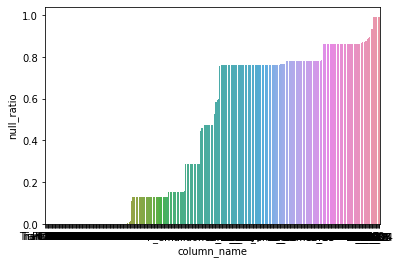

In [65]:
sns.barplot(data=null_df.sort_values(by='null_ratio'), x='column_name', y='null_ratio')

In [79]:
# 그래프를 보면 계단(?) 모양으로 결측 비율이 같은 컬럼들이 존재 -> 확인해보자
## null_ratio 0.2 단위로 끊어서 확인
### df으로 만들기

null_non_df = null_df[null_df['null_ratio'] == 0]
null_00_02_df = null_df[(null_df['null_ratio'] > 0) & (null_df['null_ratio'] <= 0.2)]
null_02_04_df = null_df[(null_df['null_ratio'] > 0.2) & (null_df['null_ratio'] <= 0.4)]
null_04_06_df = null_df[(null_df['null_ratio'] > 0.4) & (null_df['null_ratio'] <= 0.6)]
null_06_08_df = null_df[(null_df['null_ratio'] > 0.6) & (null_df['null_ratio'] <= 0.8)]
null_08_10_df = null_df[(null_df['null_ratio'] > 0.8) & (null_df['null_ratio'] <= 1.0)]

In [84]:
null_non_df.head()

,column_name,null_count,null_ratio
0,isFraud,0,0.0
1,TransactionDT,0,0.0
2,TransactionAmt,0,0.0
3,ProductCD,0,0.0
4,card1,0,0.0


In [86]:
print(null_non_df.info()) # non null
print("")
print(null_00_02_df.info()) # 0 ~ 0.2
print("")
print(null_02_04_df.info()) # 0.2 - 0.4
print("")
print(null_04_06_df.info()) # 0.4 - 0.6
print("")
print(null_06_08_df.info()) # 0.6 - 0.8
print("")
print(null_08_10_df.info()) # 0.8 - 1.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 29
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   column_name  19 non-null     object 
 1   null_count   19 non-null     int64  
 2   null_ratio   19 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 608.0+ bytes
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 5 to 374
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   column_name  162 non-null    object 
 1   null_count   162 non-null    int64  
 2   null_ratio   162 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.1+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 33 to 105
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   column_name  20 non-null     object 
 1 

- 어떤 기준으로 데이터를 날려버릴지 정하기 

## EDA

In [146]:
pd.DataFrame(train.loc[:, 'V1'].value_counts(dropna = False))

,V1
1.0,311236
NaN,279287
0.0,17


In [168]:
pd.DataFrame(train.loc[:, 'V1': 'V339'].value_counts(dropna= False))

0
V1  V2  V3  V4  V5  V6  V7  V8  V9  V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 V21 V22 V23 V24 V25 V26 V27 V28 V29 V30 V31 V32 V33 V34 V35 V36 V37 V38 V39 V40 V41 V42 V43 V44 V45 V46 V47 V48 V49 V50 V51 V52 V53 V54 V55 V56 V57 V58 V59 V60 V61 V62 V63 V64 V65 V66 V67 V68 V69 V70 V71 V72 V73 V74 V75 V76 V77 V78 V79 V80 V81 V82 V83 V84 V85 V86 V87 V88 V89 V90 V91 V92 V93 V94 V95  V96  V97  V98 V99 V100 V101 V102 V103 V104 V105 V106 V107 V108 V109 V110 V111 V112 V113 V114 V115 V116 V117 V118 V119 V120 V121 V122 V123 V124 V125 V126        V127        V128        V129       V130       V131       V132   V133   V134   V135 V136 V137 V138 V139 V140 V141 V142 V143 V144 V145 V146 V147 V148 V149 V150 V151 V152 V153 V154 V155 V156 V157 V158 V159  V160  V161  V162  V163  V164   V165   V166 V167 V168 V169 V170 V171 V172 V173 V174 V175 V176 V177 V178 V179 V180 V181 V182 V183 V184 V185 V186 V187 V188 V189 V190 V191 V192 V193 V194 V195 V196 V197 V198 V199 V200 V201 V202   V203   V204   V205  V206 V207  V208  V209  V210  V211   V212   V213   V214 V215 V216 V217 V218 V219 V220 V221 V222 V223 V224 V225 V226 V227 V228 V229 V230 V231 V232 V233 V234 V235 V236 V237 V238 V239 V240 V241 V242 V243 V244 V245 V246 V247 V248 V249 V250 V251 V252 V253 V254 V255 V256 V257 V258 V259 V260 V261 V262 V263   V264   V265   V266  V267  V268  V269  V270  V271  V272  V273   V274   V275   V276 V277 V278 V279 V280 V281 V282 V283 V284 V285 V286 V287 V288 V289 V290 V291 V292 V293 V294 V295 V296 V297 V298 V299 V300 V301 V302 V303 V304 V305 V306        V307        V308        V309       V310       V311 V312       V313  V314  V315  V316   V317   V318   V319 V320 V321 V322 V323 V324 V325 V326 V327 V328 V329 V330 V331   V332   V333   V334  V335  V336  V337 V338 V339       
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0  0.0  0.0 0.0 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.000000    0.000000    0.000000    0.000000   0.000000   0.000000   0.0    0.0    0.0    0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN    NaN   NaN  NaN   NaN   NaN   NaN   NaN    NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN    NaN  NaN  NaN  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.000000    0.000000    0.000000    0.000000   0.000000   0.0  0.000000   0.0   0.0   0.0   0.0    0.0    0.0    0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN    NaN   NaN   NaN   NaN  NaN  NaN   39086
NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 0.0  0.0  0.0  0.0 0.0 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [165]:
pd.DataFrame((train.loc[:, 'V1': 'V50']))

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2987002,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2987003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577536,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3577537,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [159]:
pd.DataFrame((train.loc[:, 'V95']))

,V95
TransactionID,
2987000,0.0
2987001,0.0
2987002,0.0
2987003,1.0
2987004,0.0
...,...
3577535,0.0
3577536,0.0
3577537,0.0


In [162]:
pd.DataFrame((train.loc[:, 'V96']))

,V96
TransactionID,
2987000,1.0
2987001,0.0
2987002,0.0
2987003,48.0
2987004,0.0
...,...
3577535,1.0
3577536,0.0
3577537,0.0


In [184]:
vixx = [[train.iloc[:,i].value_counts(dropna=False)] for i in range(55,393)]
vixx

[[1.0    298894
  NaN    279287
  2.0     10926
  3.0      1181
  4.0       163
  5.0        36
  6.0        30
  0.0        20
  7.0         2
  8.0         1
  Name: V2, dtype: int64],
 [1.0    290583
  NaN    279287
  2.0     17763
  3.0      2335
  4.0       403
  5.0        93
  6.0        34
  0.0        20
  7.0        18
  8.0         3
  9.0         1
  Name: V3, dtype: int64],
 [NaN    279287
  1.0    246500
  0.0     56687
  2.0      7385
  3.0       564
  4.0        88
  5.0        26
  6.0         3
  Name: V4, dtype: int64],
 [NaN    279287
  1.0    242883
  0.0     54276
  2.0     12610
  3.0      1200
  4.0       193
  5.0        55
  6.0        36
  Name: V5, dtype: int64],
 [1.0    298627
  NaN    279287
  2.0     11319
  3.0      1044
  4.0       180
  5.0        46
  0.0        18
  6.0        11
  7.0         5
  8.0         2
  9.0         1
  Name: V6, dtype: int64],
 [1.0    291485
  NaN    279287
  2.0     17464
  3.0      1823
  4.0       337
  5.0        83
 

In [185]:
len(vixx)

338

In [186]:
vixx[0][0]

1.0    298894
NaN    279287
2.0     10926
3.0      1181
4.0       163
5.0        36
6.0        30
0.0        20
7.0         2
8.0         1
Name: V2, dtype: int64

In [187]:
V = []
# for i in range (1, 339):
#     vixx[i][0].append(V)

vixx[1][0].append(V)
    
print(V)

[]


/var/folders/7h/7_rtz1ks11j2736fb2g5m0440000gn/T/ipykernel_1189/1264369137.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vixx[1][0].append(V)


In [191]:
df_vixx = pd.DataFrame(vixx, index=False)

TypeError: Index(...) must be called with a collection of some kind, False was passed

In [190]:
df_vixx

,0
0,1.0 298894 NaN 279287 2.0 10926 3.0 ...
1,1.0 290583 NaN 279287 2.0 17763 3.0 ...
2,NaN 279287 1.0 246500 0.0 56687 2.0 ...
3,NaN 279287 1.0 242883 0.0 54276 2.0 ...
4,1.0 298627 NaN 279287 2.0 11319 3.0 ...
...,...
333,NaN 508189 0.0 72668 2301.0 ...
334,NaN 508189 0.0 75098 50.0 ...
335,NaN 508189 0.0 73464 100.0 ...
336,NaN 508189 0.0 72114 100.0 ...


In [174]:
pd.DataFrame(train.iloc[:,55:392].value_counts(dropna=False))

0
V2  V3  V4  V5  V6  V7  V8  V9  V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 V21 V22 V23 V24 V25 V26 V27 V28 V29 V30 V31 V32 V33 V34 V35 V36 V37 V38 V39 V40 V41 V42 V43 V44 V45 V46 V47 V48 V49 V50 V51 V52 V53 V54 V55 V56 V57 V58 V59 V60 V61 V62 V63 V64 V65 V66 V67 V68 V69 V70 V71 V72 V73 V74 V75 V76 V77 V78 V79 V80 V81 V82 V83 V84 V85 V86 V87 V88 V89 V90 V91 V92 V93 V94 V95  V96  V97  V98 V99 V100 V101 V102 V103 V104 V105 V106 V107 V108 V109 V110 V111 V112 V113 V114 V115 V116 V117 V118 V119 V120 V121 V122 V123 V124 V125 V126        V127        V128        V129       V130       V131       V132   V133   V134   V135 V136 V137 V138 V139 V140 V141 V142 V143 V144 V145 V146 V147 V148 V149 V150 V151 V152 V153 V154 V155 V156 V157 V158 V159  V160  V161  V162  V163  V164   V165   V166 V167 V168 V169 V170 V171 V172 V173 V174 V175 V176 V177 V178 V179 V180 V181 V182 V183 V184 V185 V186 V187 V188 V189 V190 V191 V192 V193 V194 V195 V196 V197 V198 V199 V200 V201 V202   V203   V204   V205  V206 V207  V208  V209  V210  V211   V212   V213   V214 V215 V216 V217 V218 V219 V220 V221 V222 V223 V224 V225 V226 V227 V228 V229 V230 V231 V232 V233 V234 V235 V236 V237 V238 V239 V240 V241 V242 V243 V244 V245 V246 V247 V248 V249 V250 V251 V252 V253 V254 V255 V256 V257 V258 V259 V260 V261 V262 V263   V264   V265   V266  V267  V268  V269  V270  V271  V272  V273   V274   V275   V276 V277 V278 V279 V280 V281 V282 V283 V284 V285 V286 V287 V288 V289 V290 V291 V292 V293 V294 V295 V296 V297 V298 V299 V300 V301 V302 V303 V304 V305 V306        V307        V308        V309       V310       V311 V312       V313  V314  V315  V316   V317   V318   V319 V320 V321 V322 V323 V324 V325 V326 V327 V328 V329 V330 V331   V332   V333   V334  V335  V336  V337 V338       
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0  0.0  0.0 0.0 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.000000    0.000000    0.000000    0.000000   0.000000   0.000000   0.0    0.0    0.0    0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN    NaN   NaN  NaN   NaN   NaN   NaN   NaN    NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN    NaN  NaN  NaN  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.000000    0.000000    0.000000    0.000000   0.000000   0.0  0.000000   0.0   0.0   0.0   0.0    0.0    0.0    0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN    NaN   NaN   NaN   NaN  NaN   39086
NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 0.0  0.0  0.0  0.0 0.0 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  